# Redimensionamiento de imágenes en visión artificial (Resizing in computer vision)

En los modelos de visión artificial, una técnica común es reducir la dimensión de las imágenes ((224x224),(299x299),etc) con el objetivo de permitir el parendizade por mini-lotes (mini-batch) y mejorar así la precisión del clasificador, es decir, de la red neuronal. 

*Nota*: Tanto el entrenamiento como la validación, se llevan a cabo con esta nueva resolución.

En general, usamos métodos de escalado de imágenes como la interpolación bilinear, de esta manera, las imágenes redimensionadas no pierden muchas características del carácter perceptivo para los ojos humanos. El objetivo del presente estudio es optimizar la calidad de las imágenes para los modelos de visión artificial.

Para ello, planeteamos la siguiente pregunta: Para una resolución de imagen y un modelo dados, ¿cómo cambiar de la mejor manera el tamaño de las imágenes?

En este caso, trataremos de mejorar el rendimiento de los modelos de vision artificial, preentrenados con *ImageNet-1k*, como DenseNet-121, ResNet-50, MobileNetV2, y EfficientNets. 
*Nota*: Utilizaremos el dataset de imágenes Cats and Dogs y utilizaremos la arquitectura DenseNet-121.

**DenseNet-121**: Esta arquitectura, se basa en una red neuronal convolucional (DenseNet), que se trata de una red completamente conectada.

En particular, el modelo DenseNet-121 es una estructura de red neuronal convolucional con 201 capas de profundidad, preentrenada con más de un millón de imágenes de ImageNet. La base de datos para el entreno de la red consta de 1000 categorías de objetos.

El tamaño de las imágenes es de 224x224

# Instalación de librerías y preparación del entorno

In [1]:
#!pip3 install tensorflow_datasets

In [2]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np

In [3]:
try: 
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: 
    strategy = tf.distribute.MirroredStrategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


# Definición de hiperparámetros

Debemos definir una forma fija (Dimensiones) para las imágenes en cada lote, para así poder facilitar el aprendizaje de los mini-lotes. Es por este motivo por el que tenemos un reescalado inicial de las imágenes. 

En primer lugar, cambiamos el tamaño de las imágenes a (300x300), para posteriormente aprender su representación óptima para la resolución (150x150).

In [4]:
INP_SIZE = (300, 300)
TARGET_SIZE = (150, 150)
INTERPOLATION = "bilinear" # Se pueden utilizar otras, como la bicúbica

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 5

# Carga y preparación del dataset

Utilizaremos el 40% del dataset completo para el entrenamiento, y un 10% para validación.

In [5]:
train_ds, validation_ds , test_ds = tfds.load(
    "cats_vs_dogs", # Nombre del dataset
    # Reserve 10% for validation
    split=["train[:40%]", "train[40%:50%]","train[95%:]"], # Entrenamiento, validación y testeo
    as_supervised=True, # Modelo supervisado
)


# Definimos la función para el preprocesamiento de las imágenes del dataset
def preprocess_dataset(image, label):
    image = tf.image.resize(image, (INP_SIZE[0], INP_SIZE[1])) # Reescalado de la imagen
    label = tf.one_hot(label, depth=2) # One hot encoding
    return (image, label)


train_ds = (
    train_ds.shuffle(BATCH_SIZE * 100)
    .map(preprocess_dataset, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
validation_ds = (
    validation_ds.map(preprocess_dataset, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.map(preprocess_dataset, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

print(train_ds)
print(validation_ds)

# Definiciñon de las utilidades de cambio de tamaño (learnable resizer utilities)


<img src = 'learnable_resizer.png'>

<img src = 'resizing.png'>

In [6]:
# función para los bloques de convolución 
def conv_block(x, filters, kernel_size, strides, activation=layers.LeakyReLU(0.2)):
    x = layers.Conv2D(filters, kernel_size, strides, padding="same", use_bias=False)(x) # Convolución 2D
    x = layers.BatchNormalization()(x) # BatchNormalization: transformación para un output: mean approx 0 sd approx 1
    if activation:
        x = activation(x)
    return x


# función para el cambio de tamaño: resizing block
def res_block(x):
    inputs = x
    x = conv_block(x, 16, 3, 1)
    x = conv_block(x, 16, 3, 1, activation=None)
    return layers.Add()([inputs, x])

# Definición de la red neuronal convolucional
def get_learnable_resizer(filters=16, num_res_blocks=1, interpolation=INTERPOLATION):
    inputs = layers.Input(shape=[None, None, 3])

    # First, perform naive resizing.
    naive_resize = layers.Resizing(
        *TARGET_SIZE, interpolation=interpolation
    )(inputs)

    # First convolution block without batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=7, strides=1, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)

    # Second convolution block with batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Intermediate resizing as a bottleneck.
    bottleneck = layers.Resizing(
        *TARGET_SIZE, interpolation=interpolation
    )(x)

    # Residual passes.
    for _ in range(num_res_blocks):
        x = res_block(bottleneck)

    # Projection.
    x = layers.Conv2D(
        filters=filters, kernel_size=3, strides=1, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)

    # Skip connection.
    x = layers.Add()([bottleneck, x])

    # Final resized image.
    x = layers.Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    final_resize = layers.Add()([naive_resize, x])

    return tf.keras.Model(inputs, final_resize, name="learnable_resizer")


learnable_resizer = get_learnable_resizer()

Visualizamos la estructura de la red

In [7]:
learnable_resizer.summary()

Model: "learnable_resizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   2368        ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      (None, None, None,   0           ['conv2d[0][0]']                 
                                16)                                               

## Visualización de las salidas del módulo de transformación de imágenes

Vamos a visualizar las imágenes tras pasarlas por los pesos aleatorios del módulo para la transformación

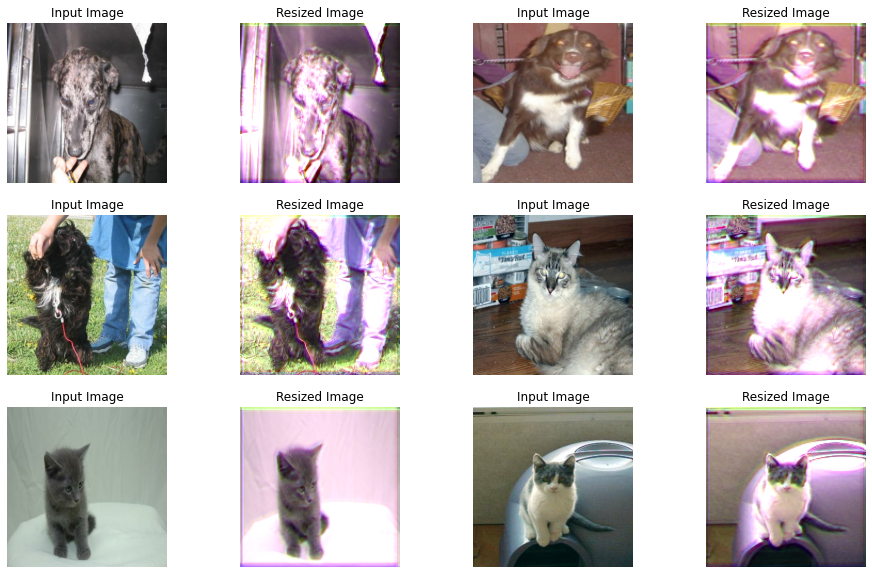

In [8]:
sample_images, _ = next(iter(train_ds))


plt.figure(figsize=(16, 10))
for i, image in enumerate(sample_images[:6]):
    image = image / 255

    ax = plt.subplot(3, 4, 2 * i + 1)
    plt.title("Input Image")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

    ax = plt.subplot(3, 4, 2 * i + 2)
    resized_image = learnable_resizer(image[None, ...])
    plt.title("Resized Image")
    plt.imshow(resized_image.numpy().squeeze())
    plt.axis("off")


# Construcción y entrenamiendo del modelo con el transformador de imágenes

In [9]:
def get_model():
    backbone = tf.keras.applications.DenseNet121(
        weights=None,
        include_top=True,
        classes=2,
        input_shape=((TARGET_SIZE[0], TARGET_SIZE[1], 3)),
    )
    backbone.trainable = True

    inputs = layers.Input((INP_SIZE[0], INP_SIZE[1], 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    x = learnable_resizer(x)
    outputs = backbone(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
model = get_model()
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer="sgd",
    metrics=["accuracy"],
)
model.fit(train_ds, validation_data=validation_ds, epochs=EPOCHS)


Epoch 1/5
146/146 [==============================] - 140s 692ms/step - loss: 0.6791 - accuracy: 0.5845 - val_loss: 0.7139 - val_accuracy: 0.5052
Epoch 2/5
146/146 [==============================] - 97s 622ms/step - loss: 0.6516 - accuracy: 0.6443 - val_loss: 0.7245 - val_accuracy: 0.5052
Epoch 3/5


## Visualización de las salidas del módulo de transformación de imágenes


In [ ]:
plt.figure(figsize=(16, 10))
for i, image in enumerate(sample_images[:6]):
    image = image / 255

    ax = plt.subplot(3, 4, 2 * i + 1)
    plt.title("Input Image")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

    ax = plt.subplot(3, 4, 2 * i + 2)
    resized_image = learnable_resizer(image[None, ...])
    plt.title("Resized Image")
    plt.imshow(resized_image.numpy().squeeze() / 10)
    plt.axis("off")

La visualización anterior y su comparación con las imágenes que veíamos antes de introducirlas al transformador muestran diferencias. Las salidas que mostramos tras haber pasado las imágnes por las 10 épocas de entrenamiento de la red son diferentes. Para los ojos humanos no tendrían sentido ni calidad alguna, pero sí para el aumento de la precisión en los modelos de visión computacional.

La siguiente tabla muestra los beneficios de usar el módulo de cambio de tamaño en comparación con el uso de la interpolación bilineal:


|Modelo|Nº parámetros (Mill)|Top-1 accuracy|
|------|-------------|--------------|
|Con el transformador de imágnees|7.051717|67.67%|
|Sin el transformador de imágnees|7.039554|60.19%|

In [ ]:
test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

model.save("learnable_resizer_model")

# Bibliografía

@InProceedings{Talebi_2021_ICCV,
    author    = {Talebi, Hossein and Milanfar, Peyman},
    title     = {Learning To Resize Images for Computer Vision Tasks},
    booktitle = {Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV)},
    month     = {October},
    year      = {2021},
    pages     = {497-506}
}
